<a href="https://colab.research.google.com/github/prafful-kumar/Blurred-Image-Recognition/blob/main/Simple_Deblurring_(pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import os
import cv2

# torch library
from torch.utils.data import Dataset, DataLoader
import torch 
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.cuda import amp

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# if using cuda
torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [4]:
use_cuda = torch.cuda.is_available()
print('use_cuda: {}'.format(use_cuda))
device = torch.device("cuda" if use_cuda else "cpu")
print("Device to be used : ",device)
!nvidia-smi

use_cuda: True
Device to be used :  cuda
Sat Sep  4 08:08:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                               

In [5]:
!cp -av "/content/drive/MyDrive/Train/Validation.tar.gz" "/content/sample_data"


'/content/drive/MyDrive/Train/Validation.tar.gz' -> '/content/sample_data/Validation.tar.gz'


In [ ]:
!cp -av "/content/drive/MyDrive/Train/train.tar.gz" "/content/sample_data"

'/content/drive/MyDrive/Train/train.tar.gz' -> '/content/sample_data/train.tar.gz'


In [6]:
!tar --gunzip --extract --verbose --file="/content/sample_data/Validation.tar.gz"
#!tar --gunzip --extract --verbose --file="/content/sample_data/train.tar.gz"


Streaming output truncated to the last 5000 lines.
Validation/sharp/sharp/00112001.png
Validation/sharp/sharp/00112002.png
Validation/sharp/sharp/00112003.png
Validation/sharp/sharp/00112004.png
Validation/sharp/sharp/00112005.png
Validation/sharp/sharp/00112006.png
Validation/sharp/sharp/00112007.png
Validation/sharp/sharp/00112008.png
Validation/sharp/sharp/00112009.png
Validation/sharp/sharp/00112010.png
Validation/sharp/sharp/00112011.png
Validation/sharp/sharp/00112012.png
Validation/sharp/sharp/00112013.png
Validation/sharp/sharp/00112014.png
Validation/sharp/sharp/00112015.png
Validation/sharp/sharp/00112016.png
Validation/sharp/sharp/00112017.png
Validation/sharp/sharp/00112018.png
Validation/sharp/sharp/00112019.png
Validation/sharp/sharp/00112020.png
Validation/sharp/sharp/00112021.png
Validation/sharp/sharp/00112022.png
Validation/sharp/sharp/00112023.png
Validation/sharp/sharp/00112024.png
Validation/sharp/sharp/00112025.png
Validation/sharp/sharp/00112026.png
Validation/sh

**MODULE_1 : Data Loader**

In [21]:
class DataGenerator(Dataset):
	
    def __init__(self, image_list):
        
        self.files = image_list
        

    #NUMBER OF FILES IN THE DATASET
    def __len__(self):
        return len(self.files)
        

    #GETTING SINGLE PAIR OF DATA
    def __getitem__(self,idx):

        #print(self.files[idx])
        sharp_image = cv2.imread(os.path.join("/content/Validation/sharp/sharp/",str(self.files[idx])))
        #print(sharp_image.shape)
        sharp_image = np.transpose(sharp_image, (2, 0, 1))
        #print("after shape", sharp_image.shape)
        blur_image = cv2.imread(os.path.join("/content/Validation/blurred/blurred/",str(self.files[idx])))
        
        blur_image = np.transpose(blur_image, (2, 0, 1))
        
        return torch.FloatTensor(sharp_image/255.), torch.FloatTensor(blur_image/255.) # sharp,blur
		
	
def load_data(image_list, batch_size=32, num_workers=10, shuffle=True):

    dataset = DataGenerator(image_list)
    data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return data_loader

In [8]:
address_list = os.listdir("/content/Validation/sharp/sharp/")

train_list,val_list,test_list = address_list[:int(0.7*len(address_list))],address_list[int(0.7*len(address_list)):int(0.9*len(address_list))],address_list[int(0.9*len(address_list)):]
train_loader = load_data(train_list, batch_size=2, num_workers=2, shuffle=True)
val_loader = load_data(val_list, batch_size=2, num_workers=2, shuffle=True)
test_loader = load_data(test_list, batch_size=1, num_workers=2, shuffle=False)

x, y = next(iter(train_loader))
print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'y = shape: {y.shape}; type: {y.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}; mean: {x.mean()}')

x = shape: torch.Size([2, 3, 270, 480]); type: torch.float32
y = shape: torch.Size([2, 3, 270, 480]); type: torch.float32
x = min: 0.0; max: 1.0; mean: 0.2284141331911087


Visualizing

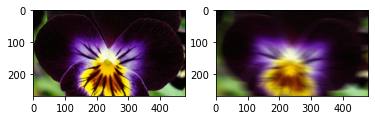

In [9]:
x = x.numpy()[0] # sharp
y = y.numpy()[0] # Blur

x = np.transpose(x, (1, 2, 0))
y = np.transpose(y, (1, 2, 0))

x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(x)
axarr[1].imshow(y)


Model

In [24]:
## U-Net Architecture

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out,batch_norm = False):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=False),
            #nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=False),
            #nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2)
        )


    def forward(self,x):
        return self.conv(x)

class U_Net(nn.Module):
    def __init__(self,img_ch,output_ch):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64,batch_norm = True)
        self.Conv2 = conv_block(ch_in=64,ch_out=128,batch_norm = True)
        self.Conv3 = conv_block(ch_in=128,ch_out=256,batch_norm = True)
        self.Conv4 = conv_block(ch_in=256,ch_out=512,batch_norm = True)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024,batch_norm = True)

        
        
        self.Up5 = nn.ConvTranspose2d(in_channels=1024,out_channels=512, kernel_size= 2, stride=2)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512,batch_norm = True)

        self.Up4 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size= 2, stride=2)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256,batch_norm = True)
        
        self.Up3 = nn.ConvTranspose2d(in_channels=256,out_channels=128, kernel_size= 2, stride=2)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128,batch_norm = True)
        
        self.Up2 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size= 2, stride=2)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64,batch_norm = True)

        self.Conv_1x1 = nn.Conv2d(64,out_channels=output_ch,kernel_size=1,stride=1,padding=0)
        #self.sig = nn.Sigmoid()
        #self.act = nn.ReLU()

    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)

        if x4.shape != d5.shape:
          d5 = TF.resize(d5, size=x4.shape[2:])

        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        if x3.shape != d4.shape:
          d4 = TF.resize(d4, size=x3.shape[2:])
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        if x2.shape != d3.shape:
          d3 = TF.resize(d3, size=x2.shape[2:])
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        if x1.shape != d2.shape:
          d2 = TF.resize(d2, size=x1.shape[2:])
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)
        # out = self.act(d1)
        # out = self.sig(d1)
        # out = torch.tanh(d1)
        out = nn.Linear(d1)
        return out

Loss Function, Weight initializer

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    
    def __init__(self, weight=None, 
                 gamma=2., reduction='none'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, input_tensor, target_tensor):
        input_tensor = input_tensor.long()
        target_tensor = target_tensor.long()
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        loss = F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob, 
            target_tensor, 
            weight=self.weight,
            reduction = self.reduction
        )
        loss = loss.type(torch.FloatTensor)
        return loss

class PSNR:
    """Peak Signal to Noise Ratio
    img1 and img2 have range [0, 255]"""

    def __init__(self):
        self.name = "PSNR"

    @staticmethod
    def __call__(img1, img2):
        dc = dice_coef(img1,img2)
        mse = torch.mean((img1 - img2) ** 2) + dc
        return 20 * torch.log10(255.0 / torch.sqrt(mse + 0.0001))



def dice_coef(y_pred,y_true):
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + 1.0)


def jacard_coef(y_pred,y_true):
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (torch.sum(y_true_f) + torch.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_pred,y_true):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_pred,y_true):
    return -dice_coef(y_true, y_pred)


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)




**SAVE CHECKPOINT**

In [12]:
def save_ckp(checkpoint, checkpoint_path):
    torch.save(checkpoint, checkpoint_path)

**LOAD CHECKPOINT**

In [13]:
def load_ckp(checkpoint_path, model, model_opt):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model_opt.load_state_dict(checkpoint['optimizer'])
    return model, model_opt, checkpoint['epoch']

**Code to check the model shape**

In [14]:
model = U_Net(img_ch=3,output_ch=3)
data = torch.rand(2, 3, 512, 512)
print(data.shape)
decoded_data = model.forward(data)
print (decoded_data.shape)

torch.Size([2, 3, 512, 512])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([2, 3, 512, 512])


**TRAIN EPOCH**

In [15]:
def train_epoch(train_loader, model, optimizer, epoch,scaler):

    progress_bar = tqdm(enumerate(train_loader))
    total_loss = 0.0
    #FL = FocalLoss()
    for step, (sharp_image, blur_image) in progress_bar:
      
      model.train()
      
      #TRANSFERRING DATA TO DEVICE
      sharp_image = sharp_image.to(device)
      blur_image = blur_image.to(device)

      optimizer.zero_grad()
      psnr = PSNR()
      mse = nn.MSELoss()
      with amp.autocast():
        #GETTING THE PREDICTED IMAGE
        pred_img = model.forward(blur_image)

        #LOSS FUNCTIONS
         
        # l1 = nn.L1Loss()
        

        #CALCULATING LOSSES
        #mse_loss = FL(pred_img, sharp_image)
        #l1_loss = l1(pred_img, sharp_image)
        psnr_loss = psnr(pred_img*255.0, sharp_image*255.0)

        #LOSS TAKEN INTO CONSIDERATION
      loss = psnr_loss
      #PSNR CAN ALSO BE TAKEN OR A LINEAR COMBINATION OF THEM

      # print(loss)

      #BACKPROPAGATING THE LOSS
      # loss.backward()
      # optimizer.step()

      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      #DISPLAYING THE LOSS
      progress_bar.set_description(
      "Epoch : {} Training Loss : {} ".format(epoch, loss))


    return model, optimizer

**VAL EPOCH**

In [16]:
def val_epoch(val_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(val_loader))
    total_loss = 0.0
    mse = nn.MSELoss()
    FL = FocalLoss()
    for step, (sharp_image, blur_image) in progress_bar:

        try :
            if sharp_image is None and blur_image is None:
                continue

            sharp_image = sharp_image.to(device)
            blur_image = blur_image.to(device)

            
            # l1 = nn.L1Loss()
            psnr = PSNR()

            model.eval()
            pred_img = model.forward(blur_image)

            # mse_loss = FL(pred_img, sharp_image)
            # l1_loss = l1(pred_img, sharp_image)
            psnr_loss = psnr(pred_img*255.0, sharp_image*255.0)

            loss = psnr_loss

            progress_bar.set_description(
            "Epoch : {} Validation Loss : {} ".format(epoch-1, loss))
        except :
            continue


**TEST EPOCH**

In [17]:
def test_epoch(test_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(test_loader))
    total_loss = 0.0
    FL = FocalLoss()

    #SETTING THE NUMBER OF IMAGES TO CHECK AFTER EACH ITERATION
    no_img_to_write = 10

    #FOLDER PATH TO WRITE THE INFERENCES
    inference_folder = "/content/try_hard_1"
    if not os.path.isdir(inference_folder):
        os.mkdir(inference_folder)

    if not os.path.isdir(os.path.join(inference_folder, str(epoch))):
        os.mkdir(os.path.join(inference_folder, str(epoch)))
    mse = nn.MSELoss()
    for step, (sharp_image, blur_image) in progress_bar:

        try:
            if sharp_image is None and blur_image is None:
                continue

            sharp_image = sharp_image.to(device)
            blur_image = blur_image.to(device)

            
            # l1 = nn.L1Loss()
            psnr = PSNR()

            model.eval()

            #PREDICTED IMAGE
            pred_img = model.forward(blur_image)

            # mse_loss = FL(pred_img, sharp_image)
            psnr_loss = psnr(pred_img*255.0, sharp_image*255.0)
            #l1_loss = l1(pred_img, sharp_image)

            loss = psnr_loss

            progress_bar.set_description(
            "Epoch : {} Test Loss : {} ".format(epoch-1, loss))

            #WRITING THE IMAGES INTO THE SPECIFIED DIRECTORY
            if(step < no_img_to_write):

                p_img = pred_img.cpu().numpy().transpose(0, 2, 3, 1) * 255
                s_img = sharp_image.cpu().numpy().transpose(0, 2, 3, 1) * 255
                b_img = blur_image.cpu().numpy().transpose(0, 2, 3, 1) * 255

                cv2.imwrite(os.path.join(inference_folder, str(epoch),
                        "img_"+str(step)+"_pred.jpg"), p_img[0])
                cv2.imwrite(os.path.join(inference_folder, str(epoch),
                        "img_"+str(step)+"_s.jpg"), s_img[0])
                cv2.imwrite(os.path.join(inference_folder, str(epoch),
                        "img_"+str(step)+"_b.jpg"), b_img[0])
        except :
            continue

**Code to control the Train, Test & Val**

In [18]:
def train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume = False):

    #PATH TO SAVE THE CHECKPOINT
    checkpoint_path = "/content/checkpoint.pt"
    scaler = amp.GradScaler()
    epoch = 0
    #IF TRAINING IS TO RESUMED FROM A CERTAIN CHECKPOINT
    if resume:
        model, optimizer, epoch = load_ckp(
            checkpoint_path, model, optimizer)

    while epoch<n_epoch:
        model, optimizer = train_epoch(train_loader, model, optimizer, epoch,scaler)
        
        #CHECKPOINT CREATION
        checkpoint = {'epoch': epoch+1, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict()}
        
        #CHECKPOINT SAVING
        save_ckp(checkpoint, checkpoint_path)
        print("Checkpoint Saved")
        epoch += 1
        #CHECKPOINT LOADING
        # model, optimizer, epoch = load_ckp(checkpoint_path, model, optimizer)
        # print("Checkpoint Loaded")
        with torch.no_grad():
            val_epoch(val_loader, model, optimizer, epoch)
            test_epoch(test_loader, model, optimizer, epoch)

**MAIN FUNCTION**

In [26]:
def main():
    
    address_list = os.listdir("/content/Validation/sharp/sharp/")
    

    # Calling Data loaders
    train_list,val_list,test_list = address_list[:int(0.7*len(address_list))],address_list[int(0.7*len(address_list)):int(0.9*len(address_list))],address_list[int(0.9*len(address_list)):]
    train_loader = load_data(train_list, batch_size=2, num_workers=2, shuffle=True)
    val_loader = load_data(val_list, batch_size=2,num_workers=2, shuffle=True)
    test_loader = load_data(test_list, batch_size=1, num_workers=2, shuffle=False)

    #CALLING THE MODEL
    model = U_Net(img_ch=3,output_ch=3)
    #UPLOADING THE MODEL TO DEVICE
    model = model.to(device)

    #DEFINING THE OPTIMIZER
    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], lr=0.01)
    
    n_epoch = 10
    
    #INDICATOR VARIABLE TO RESUME TRAINING OR START AFRESH
    resume = False
    train_val_test(train_loader, val_loader, test_loader,
                   model, optimizer, n_epoch, resume)

**CALLING THE MAIN FUNCTION**

In [20]:
main()

Epoch : 0 Training Loss : nan : : 5950it [12:22,  8.01it/s]


Checkpoint Saved


Epoch : 0 Validation Loss : nan : : 1700it [02:15, 12.54it/s]
Epoch : 0 Test Loss : nan : : 1700it [01:12, 23.48it/s]
Epoch : 1 Training Loss : nan : : 5950it [12:21,  8.02it/s]


Checkpoint Saved


Epoch : 1 Validation Loss : nan : : 1700it [02:15, 12.55it/s]
Epoch : 1 Test Loss : nan : : 1700it [01:12, 23.53it/s]
Epoch : 2 Training Loss : nan : : 5950it [12:24,  7.99it/s]


Checkpoint Saved


Epoch : 2 Validation Loss : nan : : 1700it [02:15, 12.51it/s]
Epoch : 2 Test Loss : nan : : 1700it [01:13, 23.08it/s]
Epoch : 3 Training Loss : nan : : 5950it [12:22,  8.02it/s]


Checkpoint Saved


Epoch : 3 Validation Loss : nan : : 1700it [02:15, 12.56it/s]
Epoch : 3 Test Loss : nan : : 1700it [01:12, 23.54it/s]
Epoch : 4 Training Loss : nan : : 1403it [02:55,  8.01it/s]


KeyboardInterrupt: ignored

**Module 4 : Inference**

In [ ]:
#image_folder = "/content/IMAGE_SUPER_RESOLVE_DATA/extracted_data/images"
checkpoint_path = "/content/checkpoint.pt"

#PARTICULAR IMAGE
# img_addr = os.path.join(image_folder, "Abyssinian_2.jpg")
# img = cv2.imread(img_addr)
high_res_img = cv2.imread("/content/Validation/sharp/sharp/00000900.png")
#low_res_img = cv2.resize(img,(64,64))
low_res_img = cv2.imread("/content/Validation/blurred/blurred/00000900.png")
low_res_img = np.transpose(low_res_img, (2, 0, 1))

#CONVERTING TO FLOAT TENSOR AND INCREASE ITS DIMENSION
low_res_img = torch.FloatTensor(low_res_img/255.).unsqueeze(0)


model = U_Net(img_ch=3,output_ch=3)
model = model.to(device)
optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], lr=0.0001)
model, optimizer, epoch = load_ckp(checkpoint_path, model, optimizer)
low_res_img = low_res_img.to(device)
pred_img = model.forward(low_res_img)

p_img = pred_img.detach().cpu().numpy().transpose(0, 2, 3, 1)
# p_img = cv2.cvtColor(p_img, )
inp_img = low_res_img.cpu().numpy().transpose(0, 2, 3, 1)

#DISPLAYING THE GROUND TRUTH
print("Ground Truth")
plt.imshow(high_res_img[:,:,::-1])
plt.show()

#DISPLAYING THE INPUT IMAGE
print("Input Image")
plt.imshow(inp_img[0, :,:,::-1])
plt.show()

#DISPLAYING THE PREDICTED IMAGE
print("Predicted Image")
plt.imshow(p_img[0, :,:,::-1])
plt.show()